<a href="https://colab.research.google.com/github/jzhou517/TEWH-Seizure-Project/blob/Model-Versions/RNN_Gauss_Jen_chb_all_unbalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training Models for our LSTM 

This is the official notebook you should make a copy of when training using your assigned parameters. 

### Instructions on how to get started 
First, make a copy of this notebook. 

There is an outline to the left of this notebook, which you can use to quickly skip to certain sections of the notebook. 

On the first time you run this notebook, skip to the section that says "EVERYTHING BEFORE THIS CAN BE RAN TOGETHER ON THE FIRST RUN" and click on 'Runtime' and 'Run before (Ctrl+f8). 

If your notebook crashes because of an error, simply click on 'Runtime' and 'Restart Runtime' (NOT 'Factory Reset Runtime'). After that, run all of the cells before "EVERYTHING BEFORE THIS..." EXCEPT the cell that starts with '!gsutil'. This cell downloads the data, and does not need to be rerun if you restart the runtime but already ran the notebook once. 

If you have any questions or errors to report, please Discord message me! 

-Jen

### Run every time you restart runtime

In [ ]:
!pip install mne
!pip install tensorflow_addons

     |████████████████████████████████| 7.0MB 10.4MB/s 
     |████████████████████████████████| 686kB 13.6MB/s 


In [ ]:
! python --version

Python 3.7.10


In [ ]:
import mne
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import UpSampling1D
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import model_from_json
from keras.models import load_model

### Run the one cell below only the first time you run this model 

In [ ]:
#you do not need to rerun this cell if your model crashes!
#OLD WAY OF DOWNLOADING DATA; COMMAND NO LONGER WORKS; PLEASE USE CELL BELOW
!gsutil -m cp -r \
  "gs://chbmit-1.0.0.physionet.org/chb01/" \. #change to whatever patient's data you need to access; hopefully you won't need to download the above
!gsutil -m cp -r \
  "gs://chbmit-1.0.0.physionet.org/chb03/" \.  
!gsutil -m cp -r \
  "gs://chbmit-1.0.0.physionet.org/chb07/" \.  
!gsutil -m cp -r \
  "gs://chbmit-1.0.0.physionet.org/chb22/" \.     

BadRequestException: 400 Bucket is requester pays bucket but no user project provided.
CommandException: 1 file/object could not be transferred.
BadRequestException: 400 Bucket is requester pays bucket but no user project provided.
CommandException: 1 file/object could not be transferred.
BadRequestException: 400 Bucket is requester pays bucket but no user project provided.
CommandException: 1 file/object could not be transferred.
BadRequestException: 400 Bucket is requester pays bucket but no user project provided.
CommandException: 1 file/object could not be transferred.


In [ ]:
!wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/chb01/
!wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/chb03/
!wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/chb07/
!wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/chb22/

--2021-05-25 02:22:57--  https://physionet.org/files/chbmit/1.0.0/chb01/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/chbmit/1.0.0/chb01/index.html’

physionet.org/files     [ <=>                ]   6.01K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-05-25 02:22:57 (391 MB/s) - ‘physionet.org/files/chbmit/1.0.0/chb01/index.html’ saved [6159]

Loading robots.txt; please ignore errors.
--2021-05-25 02:22:57--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2021-05-25 02:22:58 (4.13 MB/s) - ‘physionet.org/robots.txt’ saved [22/22]

-

In [ ]:
!wget -r -N -c -np https://physionet.org/files/siena-scalp-eeg/1.0.0/

--2021-05-25 02:41:16--  https://physionet.org/files/siena-scalp-eeg/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/siena-scalp-eeg/1.0.0/index.html’

physionet.org/files     [ <=>                ]   2.20K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-05-25 02:41:17 (134 MB/s) - ‘physionet.org/files/siena-scalp-eeg/1.0.0/index.html’ saved [2255]

Loading robots.txt; please ignore errors.
--2021-05-25 02:41:17--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.

--2021-05-25 02:41:17--  https://physionet.org/files/siena-scalp-eeg/1.0.0/PN00/
Reusing existing connection to physionet.org:443.
HTTP request sent, awai

## Data Modification Process
After setting up our work environment. We are ready to prepare the EEG data for our ML models. 

### Setting up empty lists and constants
Before looping through each EDF file, we want to set up the lists for our EEG data, labels, and constants such as what proportion of our data will be used for training. 

In [ ]:
# Set up lists for seizure data and labels
all_X = list() #data
all_Y = list() #labels
train_ratio = 0.8
timesteps=1280
channels=23

### Dictionary of EDF files and preictal/interictal times 
For each patient, the start and end times for preictal/interictal periods are different within each data file. As such, each patient has their own dictionary of seizure times - the key is the patient file number, and the terms are the start time, end time, and classification of the timeframe. 

In [ ]:
# Seizures dictionary
patient_names = ['01', '03', '07', '22']
chb_01 = {'03':[3003,3599.9961,'pre'], '04':[0,2996,'pre'], '09':[1466,3599.9961,'int'], '10':[0,3599.9961,'int'], '11':[0,3599.9961,'int'], '15':[1739,3599.9961,'pre'], '16':[0,1732,'pre'], '18':[1727,3599.9961,'pre'], '19':[0,1720,'pre'], '20':[0,3599.9961,'pre'], '21':[0,2663,'pre'], '22':[0,327,'pre'], '26':[1870,3600,'pre'], '27':[0,1862,'pre'], '32':[2553,3599.9961,'int'], '33':[0,3599.9961,'int'], '34':[0,3599.9961,'int']}
chb_03 = {'01':[0,362,'pre'], '02':[0,731,'pre'], '03':[0,432,'pre'], '04':[0,2162,'pre'], '08':[2186,3600,'int'], '09':[0,3600, 'int'], '10':[0,3600,'int'], '34':[0,1982,'pre'], '35':[0,2592,'pre'],'36':[0,1725,'pre']}
chb_07 = {'12':[14092,14400,'pre'],'13':[0,3285,'pre'],'15':[0,14400,'int'],'16':[0,14400,'int'],'17':[0,14400,'int'],'18':[0,11472,'int'],'19':[10088,13688,'pre']}
chb_22 = {'20':[0,3367,'pre'], '25':[0,3139,'pre'], '38':[0,1263,'pre']}


### Reading in and cropping files using the dictionary 
Using a dictionary, we can read in patient files and perform operations on them at large. 

In [ ]:
def read_files(name, key):
  path = 'physionet.org/files/chbmit/1.0.0/chb' + name + '/chb' + name + '_' + key + '.edf' #Can modify to loop through all files
  raw = mne.io.read_raw_edf(path, preload=True, stim_channel='auto')
  # Need to drop certain channels so they're all the same
  if (name == '20'):
    raw = raw.drop_channels(['.-0', '.-1', '.-2', '.-3', '.-4'])
  if (name == '21' or name == '22'):
    raw = raw.drop_channels(['--0', '--1', '--2', '--3', '--4'])
  if (name == '09'):
    raw = raw.drop_channels(['VNS']) # NO MORE 24 CHANNELS
  return raw

In [ ]:
def crop_data(e):
  max_time = (raw.n_times - 1) / raw.info['sfreq'] #t_max can't exceed maximum time
  if e[2] == 'int' and max_time > 3600: 
    t_max = 3600
  elif e[1] > max_time:
    t_max = None
  else:
    t_max = e[1]
  crop = raw.crop(tmin=e[0], tmax=t_max, include_tmax=True)
  return crop

### Epoching data 
Epochs are essentially time segments - they are a way to further divide our time series data to feed into our ML model. 

MNE makes epochs from "events," which are marked by the researcher. This set has no "events," but since we want 5-second epochs, we can make an event every 5 seconds. 

In [ ]:
def make_epochs(crop):
  events = mne.make_fixed_length_events(crop, id=1, start=0, stop=None, duration=5.0, first_samp=True, overlap=0.0)
  epochs = mne.Epochs(crop, events, tmin=-0.1, tmax=4.895) # how much overlap??????
  epochs_array = epochs.get_data()
 #reshaped_mat = np.reshape(mat[:, mat.shape[1]//256*256], (23, -1, 256)) 
  return epochs_array

### Sorting, shuffling, and train-test split
X will hold all of our EEG epochs. 
Y will hold all of the labels that correspond to each epoch. 

After we sort the data, we use zip to correspond each X value to each Y value, then unzip after shuffling data. 

Lastly, we make a train and test set for the data - the train set is the data the model learns on, while the test set is used to evaluate how well the model learned the data. 

In [ ]:
def sort(epochs_array, e, all_X, all_Y):
  all_X = list(all_X)
  all_Y = list(all_Y)
  for j in range(epochs_array.shape[0]):
    all_X.append(epochs_array[j])
    all_Y.append(e[2])
  #print(channel_no)
  return all_X, all_Y

In [ ]:
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def shuffle_split(all_X, all_Y, train_ratio):
  import random
  dataset = list(zip(all_X, all_Y))
  random.shuffle(dataset)
  all_X, all_Y = list(zip(*dataset))
  
  import math
  cutoff = math.floor(train_ratio*len(all_X))
  x_train = np.array(all_X[:cutoff], ndmin=1) #this needs to be reshaped to num channels x timepoints
  x_train = x_train.reshape((-1,timesteps*channels))
  t = MinMaxScaler()
  t.fit(x_train)
  x_train = t.transform(x_train)
  x_train = x_train.reshape((-1,timesteps,channels))

  y_train = np.array(all_Y[:cutoff])
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(y_train)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  y_train = onehot_encoder.fit_transform(integer_encoded)

  x_test = np.array(all_X[cutoff:], ndmin=1) #actually dev
  x_test = x_test.reshape((-1,timesteps*channels))
  x_test = t.transform(x_test)
  x_test = x_test.reshape((-1,timesteps,channels))

  y_test = np.array(all_Y[cutoff:])
  integer_encoded2 = label_encoder.fit_transform(y_test)
  integer_encoded2 = integer_encoded2.reshape(len(integer_encoded2), 1)
  y_test = onehot_encoder.fit_transform(integer_encoded2)

  return all_X, all_Y, x_train, y_train, x_test, y_test

In [ ]:
#looping through all patients 
for name in patient_names: 
  directory_name = globals()['chb_' + name]

  for key in directory_name:
    e = directory_name[key]
    #print (directory_name, key)

  # reading in the files
    raw = read_files(name,key)
  
  # cropping the raw data
    crop = crop_data(e)

    del raw
  
  # epoching the raw data
    epochs_array = make_epochs(crop)

    del crop

  # sorting the data into X and Y
    all_X, all_Y = sort(epochs_array, e, all_X, all_Y)
    
    del epochs_array

  # train-test split
all_X, all_Y, x_train, y_train, x_test, y_test = shuffle_split(all_X, all_Y, train_ratio)

  


##EVERYTHING BEFORE THIS CAN BE RAN TOGETHER ON THE FIRST RUN

In [ ]:
#if your model crashes do runtime> run all before you can automatically run all the preprocessing stuff that doesn't require you to make changes
#Sruja's revised DCAE same as athulya and zains except did it layer by layer instead of adding to sequential 
time_length = 1280; ecg_channels = 23; in_ch = ecg_channels; out_ch = 46;
from keras import layers
input_thingy=keras.Input(shape=(time_length, in_ch))
x = layers.Conv1D(filters=out_ch, kernel_size=3, padding="same", strides=1,activation='relu')(input_thingy)
x= layers.BatchNormalization(axis=-1)(x)
x= layers.MaxPooling1D(pool_size = 2, padding = 'valid')(x)
in_ch = out_ch;
out_ch *= 2
x = layers.Conv1D(filters=out_ch, kernel_size=3, padding="same", strides=1,activation='relu')(x)
x= layers.BatchNormalization(axis=-1)(x)
x= layers.MaxPooling1D(pool_size = 2, padding = 'valid')(x)
in_ch = out_ch;
out_ch *= 2
x = layers.Conv1D(filters=out_ch, kernel_size=3, padding="same", strides=1,activation='relu')(x)
x= layers.BatchNormalization(axis=-1)(x)
bottleneck= layers.MaxPooling1D(pool_size = 2, padding = 'valid')(x)
in_ch = out_ch;
out_ch *= 2
x=layers.Conv1D(filters=out_ch, kernel_size=3, padding="same", strides=1)(bottleneck)
  
  # Your encoded product is of size: Batch x Time_Length / (2**network_depth) x out_ch * 2**(network_depth-1)

#https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

out_ch = out_ch / 4

x=layers.Conv1D(filters=out_ch, kernel_size=3, padding="same", strides=1)(x)

x=layers.ReLU()(x)
x=layers.BatchNormalization(axis=-1)(x)
in_ch = out_ch;
out_ch = out_ch // 2
x=layers.UpSampling1D(size=2)(x)
x=layers.Conv1D(filters=out_ch, kernel_size=3, padding="same", strides=1)(x)

x=layers.Conv1D(filters=out_ch, kernel_size=3, padding="same", strides=1)(x)

x=layers.ReLU()(x)
x=layers.BatchNormalization(axis=-1)(x)
in_ch = out_ch;
out_ch = out_ch // 2
x=layers.UpSampling1D(size=2)(x)
x=layers.Conv1D(filters=out_ch, kernel_size=3, padding="same", strides=1)(x)
x=layers.Conv1D(filters=out_ch, kernel_size=3, padding="same", strides=1)(x)

x=layers.ReLU()(x)
x=layers.BatchNormalization(axis=-1)(x)
in_ch = out_ch;
out_ch = out_ch // 2
x=layers.UpSampling1D(size=2)(x)
x=layers.Conv1D(filters=out_ch, kernel_size=3, padding="same", strides=1)(x)

x=layers.Dense(ecg_channels)(x)
x= layers.Dense(ecg_channels)(x)




###Change 1: autoencoder optimizer


* Do not rerun this cell if you already saved the autoencoder.

In [ ]:
autoencoder = keras.Model(input_thingy, x)
optimizer=keras.optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer=optimizer, loss = 'mse', metrics = 'accuracy')

encoder_only = keras.Model(input_thingy, bottleneck)
autoencoder.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1280, 23)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1280, 46)          3220      
_________________________________________________________________
batch_normalization (BatchNo (None, 1280, 46)          184       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 640, 46)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 640, 92)           12788     
_________________________________________________________________
batch_normalization_1 (Batch (None, 640, 92)           368       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 320, 92)           0     

###Change 2: autoencoder epochs

* As you'll see below, you should not have to retrain your autoencoder from scratch if your runtime disconnects throughout the day. 
* Do not rerun this cell if you already saved the autoencoder.


In [ ]:
autoencoder.fit(x_train,x_train, epochs = 50) # change epochs value based on sheet
# use: https://machinelearningmastery.com/autoencoder-for-classification/

Epoch 1/50
414/414 [==============================] - 159s 366ms/step - loss: 0.0568 - accuracy: 0.0421
Epoch 2/50
414/414 [==============================] - 159s 384ms/step - loss: 0.0046 - accuracy: 0.0453
Epoch 3/50
414/414 [==============================] - 151s 365ms/step - loss: 0.0041 - accuracy: 0.0568
Epoch 4/50
414/414 [==============================] - 151s 364ms/step - loss: 0.0034 - accuracy: 0.0804
Epoch 5/50
414/414 [==============================] - 151s 364ms/step - loss: 0.0030 - accuracy: 0.0935
Epoch 6/50
414/414 [==============================] - 158s 382ms/step - loss: 0.0025 - accuracy: 0.1189
Epoch 7/50
414/414 [==============================] - 152s 367ms/step - loss: 0.0022 - accuracy: 0.1408
Epoch 8/50
414/414 [==============================] - 154s 371ms/step - loss: 0.0021 - accuracy: 0.1582
Epoch 9/50
414/414 [==============================] - 153s 370ms/step - loss: 0.0019 - accuracy: 0.1717
Epoch 10/50
414/414 [==============================] - 161s 388m

* Do not rerun this cell if you already saved the autoencoder.

In [ ]:
encoder_only = keras.Model(input_thingy, bottleneck)
encoder_only.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1280, 23)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1280, 46)          3220      
_________________________________________________________________
batch_normalization (BatchNo (None, 1280, 46)          184       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 640, 46)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 640, 92)           12788     
_________________________________________________________________
batch_normalization_1 (Batch (None, 640, 92)           368       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 320, 92)           0   

### After training your autoencoder, save the model using these steps below.

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
model_json = encoder_only.to_json()


with open("encoder_0.01.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
encoder_only.save_weights("encoder_0.01.h5")

****MAKE SURE TO CLICK ON THE FOLDER IN THE SIDEBAR AND DOWNLOAD the .json and .h5 BECAUSE YOUR NOTEBOOK WILL DISCONNECT AFTER ONE DAY. 

### Load your trained autoencoder with the cells  below. 

---



In [ ]:
from google.colab import files
files.upload()
# Click on the upload files button that appears to upload the h5 and json to this notebook. 

Saving encoder_0.01.json to encoder_0.01.json
Saving encoder_0.01.h5 to encoder_0.01.h5


{'encoder_0.01.h5': b'\x89HDF\r\n\x1a\n\x00\x00\x00\x00\x00\x08\x08\x00\x04\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x08\x9f\x04\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00`\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x88\x00\x00\x00\x00\x00\x00\x00\xa8\x02\x00\x00\x00\x00\x00\x00\x01\x00\x06\x00\x01\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x10\x00\x10\x00\x00\x00\x00\x00 \x03\x00\x00\x00\x00\x00\x00\xe0\x01\x00\x00\x00\x00\x00\x00TREE\x00\x00\x02\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00P\x00\x00\x00\x00\x00\x00\x00(\x9a\x04\x00\x00\x00\x00\x00\xa0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

In [ ]:
# load json and create model
json_file = open('encoder_0.01.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
encoder_only = model_from_json(loaded_model_json)

# load weights into new model
encoder_only.load_weights("encoder_0.01.h5")
print("Loaded model from disk")

encoder_only.save('encoder_0.01.hdf5')
loaded_model=load_model('encoder_0.01.hdf5')

Loaded model from disk


RUN CELL BELOW

In [ ]:
optimizer=keras.optimizers.Adam(learning_rate=0.01)
encoder_only.compile(optimizer=optimizer, loss = 'mse', metrics = 'accuracy')
x_train = encoder_only.predict(x_train)

###Change 3: LSTM optimizer (initial learning, decay, decay steps) and regularizer



* Do not rerun this cell if you already saved the LSTM.

In [ ]:
# defining LSTM model 
# defining LSTM model 
from keras.layers import GaussianNoise
class ResLSTM(keras.layers.Layer):
    def __init__(self, c_out):
        super(ResLSTM, self).__init__()
        self.rec = layers.Bidirectional(keras.layers.LSTM(units=c_out,return_sequences=True))
        self.res = Conv1D(2*c_out, kernel_size=1)
    def call(self, x):
      return self.rec(x) + self.res(x)
class Network(keras.layers.Layer):
    def __init__(self):
t_timesteps = 160 #from encoded input, for now we can test on the raw data we have
features_per_step = 184 #the channels can be features for now
regularizer = tf.keras.regularizers.l1(l1 = 0.01)
model = Sequential()
model.add(LSTM(20))
model.add(Bidirectional(LSTM(20), input_shape=(t_timesteps,features_per_step)))
model.add(GaussianNoise(0.5))
model.add(Dense(2, activation='sigmoid',kernel_regularizer=regularizer))
#DIY optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.5)
#choose an optimizer
#optimizer = keras.optimizers.SGD(learning_rate=lr_schedule) #this is the DIY optimizer which we don't really use anymore
#optimizer = tfa.optimzers.AdamW()
#optimizer = tfa.optimizers.AdamW(learning_rate = 2e-4, weight_decay = 0.3)
optimizer = keras.optimizers.Adam(learning_rate = 2e-4) 
#optimizer = keras.optimizers.Adam(weight_decay= 0.3)
#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-06)
# change optimizer learning rate and weight decay based on sheet

#choose a regularizer 

#regularizer = tf.keras.regularizers.l2(l2=0.01)
#regularizer = tf.keras.regularizers.l1_l2(l1 = 0.01, l2 = 0.01)


NameError: ignored

###Change 4: LSTM loss


In [ ]:
#set loss function to either binary or categorical cross entropy
#lossfunction =tf.keras.losses.CategoricalCrossentropy()
lossfunction =tf.keras.losses.BinaryCrossentropy()
auc = tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    label_weights=None,
)
precision = tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
recall = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
f1 = tfa.metrics.F1Score(num_classes=2)
model.compile(loss=lossfunction, optimizer=optimizer,metrics=['accuracy', precision, recall, auc, f1]) # change loss and optimizer value based on sheet
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 40)                32800     
_________________________________________________________________
gaussian_noise (GaussianNois (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 82        
Total params: 32,882
Trainable params: 32,882
Non-trainable params: 0
_________________________________________________________________


###Changes 5 and 6: LSTM epochs and batch size

* If you are running your training across several days and you have already trained halfway, reload your model below before running the cell that begins with "history." 

Epoch 1/200
385/385 [==============================] - 37s 82ms/step - loss: 0.8735 - accuracy: 0.5139 - precision: 0.5060 - recall: 0.5166 - auc: 0.5128 - f1_score: 0.5094 - val_loss: 0.8002 - val_accuracy: 0.5736 - val_precision: 0.5655 - val_recall: 0.5736 - val_auc: 0.5862 - val_f1_score: 0.5731
Epoch 2/200
385/385 [==============================] - 28s 74ms/step - loss: 0.8245 - accuracy: 0.5288 - precision: 0.5241 - recall: 0.5250 - auc: 0.5326 - f1_score: 0.5258 - val_loss: 0.7611 - val_accuracy: 0.5932 - val_precision: 0.6014 - val_recall: 0.5683 - val_auc: 0.6319 - val_f1_score: 0.5833
Epoch 3/200
385/385 [==============================] - 29s 74ms/step - loss: 0.7721 - accuracy: 0.5736 - precision: 0.5641 - recall: 0.5644 - auc: 0.5914 - f1_score: 0.5686 - val_loss: 0.7368 - val_accuracy: 0.5970 - val_precision: 0.5998 - val_recall: 0.5872 - val_auc: 0.6379 - val_f1_score: 0.5854
Epoch 4/200
385/385 [==============================] - 28s 72ms/step - loss: 0.7226 - accuracy: 0

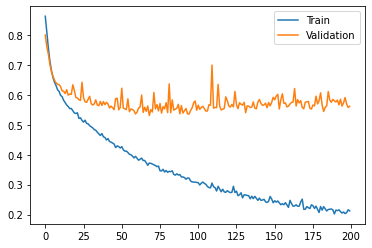

In [ ]:
history = model.fit(x_train, y_train, epochs=200, batch_size=31, verbose=1, validation_split=0.1) # change epochs and (MAYBE?) batch size based on sheet
# important thing for epochs and batch size, try to delay plateau in loss gradient as long as possible and epochs should be enough such that they go for 50% of the amount of epochs
# necessary to reach the plateau after reaching the plateau (e.g. if it takes 100 epochs to reach the beginning of a plateau, you should go for 150 epochs total)

# plot loss
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Validation')
pyplot.legend()
pyplot.show()

### Save your LSTM for later training 
* Similar to the DCAE, you can split your LSTM training into several days (i.e. 100 + 100 = 200) by saving the model, loading it in, and rerunning the cell above. 

In [ ]:
# serialize model to JSON
model_json = model.to_json()


with open("LSTM_0.01.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("LSTM.h5")

### Opening a saved LSTM

In [ ]:
from google.colab import files
files.upload()
# Click on the upload files button that appears to upload the h5 and json to this notebook. 

In [ ]:
# load json and create model
json_file = open('LSTM_0.01.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("LSTM_0.01.h5")
print("Loaded model from disk")

model.save('LSTM_0.01.hdf5')
model =load_model('LSTM_0.01.hdf5')

Loaded model from disk


## Wrapping things up 

After you've successfully ran all of your epochs, make sure to report your loss, accuracy, validation loss, and validation accuracy in [this spreadsheet.](https://docs.google.com/spreadsheets/d/1nBiO-c6ZofrugwmgVMGlIkb5jz5IogjcG_iCeajFU5s/edit?fbclid=IwAR1jha9SOPhn7WEaCCIe40feDxdl9zTigmZ0ns44kYyqhx0q_EMSpF27ti4#gid=0) Then, move your notebook to the TEWH 2020-2021 drive. 